# 1. Initialize modules

In [1]:
import gymnasium as gym
import numpy as np
import torch    
from stable_baselines3 import SAC
from pendulum_env import MuJoCoPendulumEnv
import matplotlib.pyplot as plt
import numpy as np

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
env = MuJoCoPendulumEnv() 

Using device: cpu


/opt/anaconda3/envs/rl_venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/anaconda3/envs/rl_venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


- Wrapper adds random gaussian noise at the action (torque).

In [3]:
class ActionGaussianNoiseWrapper(gym.Wrapper):
    def __init__(self, env, snr_linear=20.0):
        super().__init__(env)
        self.snr_linear = snr_linear

    def step(self, action):
        # action shape: (1,)
        signal_power = np.mean(action**2) + 1e-8

        # Noise power from SNR definition
        noise_power = signal_power / self.snr_linear
        noise_std = np.sqrt(noise_power)

        noise = np.random.normal(0.0, noise_std, size=action.shape)
        action_noisy = action + noise

        return self.env.step(action_noisy)


In [4]:
def rollout_sb3_debug(env, model, seed=0, max_steps=500, start_angle=None, start_velocity=None):
    # Prepare reset options
    reset_kwargs = {}
    if seed is not None:
        reset_kwargs['seed'] = seed
    
    if start_angle is not None:
        options = {'start_angle': start_angle}
        if start_velocity is not None:
            options['start_velocity'] = start_velocity
        reset_kwargs['options'] = options
    
    state, _ = env.reset(**reset_kwargs)
    done = False
    
    states = [state]
    actions = []
    rewards = []
    step = 0
    
    while not done and step < max_steps:
        action, _ = model.predict(state, deterministic=True)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        step += 1
        
        if done:
            print(f"Episode ended at step {step}")
            print(f"Terminated: {terminated}, Truncated: {truncated}")
            print(f"Final state: {state}")
            break
    
    return np.array(states), np.array(actions), np.array(rewards)




# 2. Normal SAC

## 2.1 Initialize model and train

In [5]:
env = ActionGaussianNoiseWrapper(env, snr_linear=0.5)

In [6]:
model = SAC(
    "MlpPolicy",
    env,
    learning_rate=3e-4,
    gamma=0.99,
    # verbose=1,
)

In [7]:
model.learn(total_timesteps=40_000)

- rollout at a specific initial condition

In [8]:
# Start at 45 degrees (π/4 radians)
print("\n--- Starting at 45° (θ = π/4) ---")
states_45, actions_45, rewards_45 = rollout_sb3_debug(env, model, start_angle=np.pi/4, start_velocity=0.0)
print(f"Episode length: {len(actions_45)}")


--- Starting at 45° (θ = π/4) ---
Episode length: 500


## 2.2 Plotting the fft of position (θ) and action

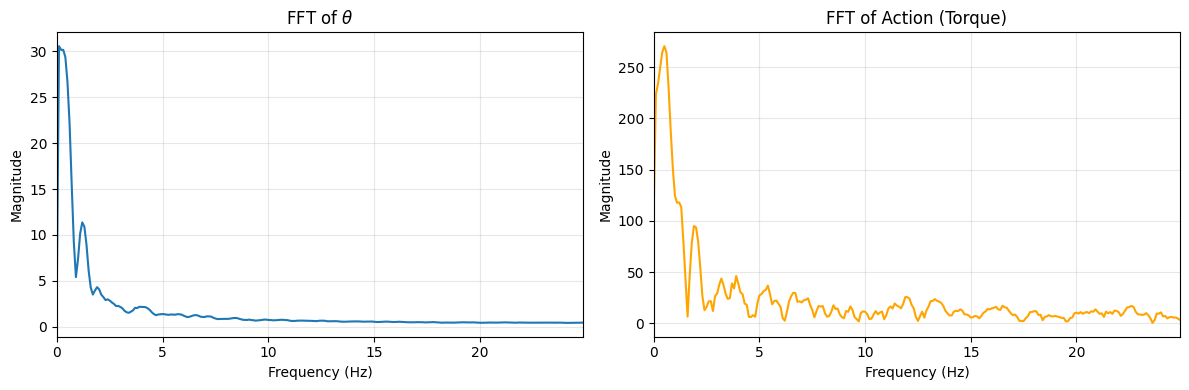

In [9]:
from scipy.fft import fft, fftfreq

# Compute and plot FFT of states and actions

dt = env.unwrapped.dt  # timestep
n_samples = len(actions_45)
freqs = fftfreq(n_samples, dt)[:n_samples // 2]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Angle: θ (computed from cos(θ) and sin(θ))
ax = axes[0]
theta = np.arctan2(states_45[:-1, 1], states_45[:-1, 0])  # atan2(sin, cos)
fft_vals = np.abs(fft(theta))[:n_samples // 2]
ax.plot(freqs, fft_vals)
ax.set_title(r'FFT of $\theta$')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.grid(True, alpha=0.3)

# Action (torque)
ax = axes[1]
action_signal = actions_45.flatten()
fft_actions = np.abs(fft(action_signal))[:n_samples // 2]
ax.plot(freqs, fft_actions, color='orange')
ax.set_title('FFT of Action (Torque)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 3. Reducing Noise

- Penalises more for high frequency actions.
- Compares action to a LPF and penalises proportional to the difference.
- Penalises high angular velocities

## 3.1 Initialize model and train

- reward = − (θ² + 0.1 θ̇² + 0.001 τ²)
         − λ_lpf (τ − τ_LPF)²
         − λ_w θ̇²


In [10]:
from scipy.signal import butter, lfilter, lfilter_zi

class BandLimitedRewardWrapper(gym.Wrapper):
    def __init__(
        self,
        env,
        fs=20.0, # sampling frequency of Pendulum-v1 = 1/0.05s
        cutoff_hz=6.0,
        lambda_lpf=0.1, 
        lambda_w=0.01
    ):
        super().__init__(env)

        self.lambda_lpf = lambda_lpf
        self.lambda_w = lambda_w

        nyq = 0.5 * fs
        self.b, self.a = butter(2, cutoff_hz / nyq, btype="low")
        self.zi = lfilter_zi(self.b, self.a)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        return obs, info

    def step(self, action):
        u = float(action[0])
        action_env = np.array([u], dtype=np.float32)

        obs, reward, terminated, truncated, info = self.env.step(action_env)

        u_lpf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_lpf = u_lpf[0]

        # ---- penalties ----
        band_penalty = -self.lambda_lpf * (u - u_lpf)**2

        _, _, theta_dot = obs
        vel_penalty = -self.lambda_w * theta_dot**2

        reward += band_penalty + vel_penalty

        return obs, reward, terminated, truncated, info


In [11]:
# Create environment with BandLimitedRewardWrapper
env_reduced = MuJoCoPendulumEnv()
env_reduced = ActionGaussianNoiseWrapper(env_reduced, snr_linear=0.5)
env_reduced = BandLimitedRewardWrapper(env_reduced, fs=1/env_reduced.unwrapped.dt, cutoff_hz=6.0)

# Train SAC model with band-limited reward
model_reduced = SAC(
    "MlpPolicy",
    env_reduced,
    learning_rate=3e-4,
    gamma=0.99,
    # verbose=1,
)

model_reduced.learn(total_timesteps=40_000)

/opt/anaconda3/envs/rl_venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/opt/anaconda3/envs/rl_venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [22]:
# Run rollout with the band-limited model
env = ActionGaussianNoiseWrapper(env_reduced, snr_linear=0.5)
states_reduced, actions_reduced, rewards_reduced = rollout_sb3_debug(env, model_reduced, start_angle=np.pi/4, start_velocity=0.0)
print(f"Episode length: {len(actions_reduced)}")
print(f"Total reward: {rewards_reduced.sum():.2f}")
print(f"States shape: {states_reduced.shape}, Actions shape: {actions_reduced.shape}")

Episode length: 500
Total reward: 247.17
States shape: (501, 3), Actions shape: (500, 1)


## 3.2 Plotting the fft of position (θ) and action

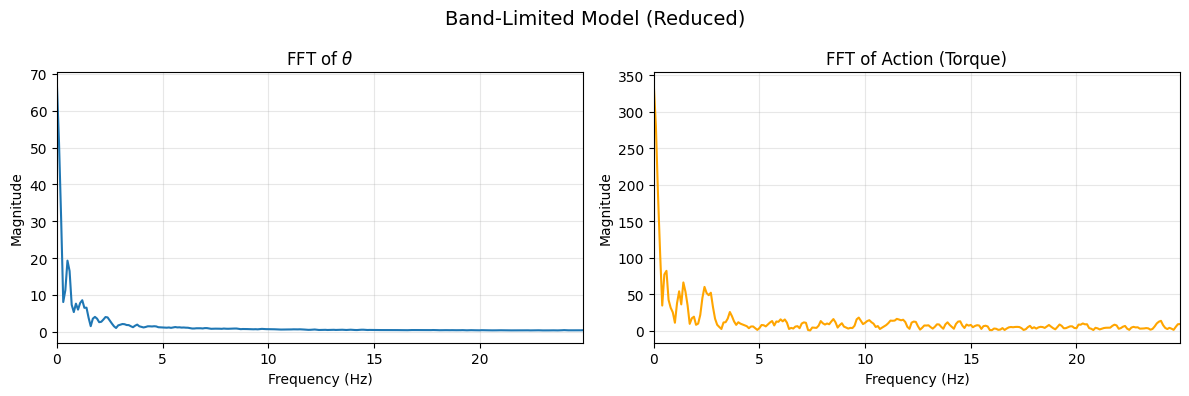

In [23]:
from scipy.fft import fft, fftfreq

dt = env.unwrapped.dt
n_samples = len(actions_reduced)
freqs = fftfreq(n_samples, dt)[:n_samples // 2]

# --- Plot 1: Reduced model FFT ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Band-Limited Model (Reduced)', fontsize=14)

ax = axes[0]
theta_reduced = np.arctan2(states_reduced[:-1, 1], states_reduced[:-1, 0])
fft_vals = np.abs(fft(theta_reduced))[:n_samples // 2]
ax.plot(freqs, fft_vals)
ax.set_title(r'FFT of $\theta$')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.grid(True, alpha=0.3)

ax = axes[1]
fft_actions_reduced = np.abs(fft(actions_reduced.flatten()))[:n_samples // 2]
ax.plot(freqs, fft_actions_reduced, color='orange')
ax.set_title('FFT of Action (Torque)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 4. Comparing the two models

## 4.1 Plotting the FFT

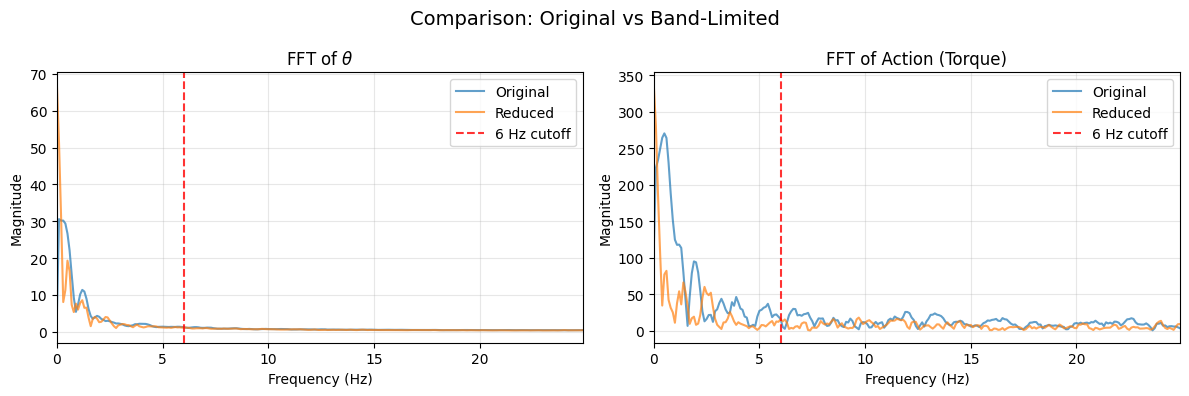

In [24]:
# --- Plot 2: Overlay comparison ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Comparison: Original vs Band-Limited', fontsize=14)

# θ comparison
ax = axes[0]
theta_orig = np.arctan2(states_45[:-1, 1], states_45[:-1, 0])
theta_reduced = np.arctan2(states_reduced[:-1, 1], states_reduced[:-1, 0])
fft_theta = np.abs(fft(theta_orig))[:n_samples // 2]
fft_theta_reduced = np.abs(fft(theta_reduced))[:n_samples // 2]
ax.plot(freqs, fft_theta, label='Original', alpha=0.7)
ax.plot(freqs, fft_theta_reduced, label='Reduced', alpha=0.7)
ax.axvline(x=6, color='red', linestyle='--', alpha=0.8, label='6 Hz cutoff')
ax.set_title(r'FFT of $\theta$')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.legend()
ax.grid(True, alpha=0.3)

# Action comparison
ax = axes[1]
fft_actions_orig = np.abs(fft(actions_45.flatten()))[:n_samples // 2]
fft_actions_reduced = np.abs(fft(actions_reduced.flatten()))[:n_samples // 2]
ax.plot(freqs, fft_actions_orig, label='Original', alpha=0.7)
ax.plot(freqs, fft_actions_reduced, label='Reduced', alpha=0.7)
ax.axvline(x=6, color='red', linestyle='--', alpha=0.8, label='6 Hz cutoff')
ax.set_title('FFT of Action (Torque)')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Magnitude')
ax.set_xlim(0, freqs[-1])
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.2 Comparing energy 

In [25]:
# Calculate energy (sum of squared magnitudes) for all 4 signals

# Original model signals
theta_orig = np.arctan2(states_45[:-1, 1], states_45[:-1, 0])
action_orig = actions_45.flatten()

# Band-limited model signals  
theta_reduced = np.arctan2(states_reduced[:-1, 1], states_reduced[:-1, 0])
action_reduced = actions_reduced.flatten()

# Calculate FFT magnitudes
fft_theta_orig = np.abs(fft(theta_orig))
fft_action_orig = np.abs(fft(action_orig))
fft_theta_reduced = np.abs(fft(theta_reduced))
fft_action_reduced = np.abs(fft(action_reduced))

# Calculate energy (sum of squared magnitudes)
energy_theta_orig = np.sum(fft_theta_orig**2)
energy_action_orig = np.sum(fft_action_orig**2)
energy_theta_reduced = np.sum(fft_theta_reduced**2)
energy_action_reduced = np.sum(fft_action_reduced**2)

# Calculate energy for frequencies > 6 Hz
dt = env.unwrapped.dt
n_samples = len(action_orig)
freqs = fftfreq(n_samples, dt)
high_freq_mask = np.abs(freqs) > 6.0

# Energy above 6 Hz
energy_theta_orig_high = np.sum(fft_theta_orig[high_freq_mask]**2)
energy_action_orig_high = np.sum(fft_action_orig[high_freq_mask]**2)
energy_theta_reduced_high = np.sum(fft_theta_reduced[high_freq_mask]**2)
energy_action_reduced_high = np.sum(fft_action_reduced[high_freq_mask]**2)

print(f"\nHigh-Frequency Energy (f > 6 Hz):")
print("=" * 50)
print(f"Original Model:")
print(f"  θ (angle) > 6Hz:      {energy_theta_orig_high:.4e}")
print(f"  Action > 6Hz:         {energy_action_orig_high:.4e}")
print(f"\nBand-Limited Model:")
print(f"  θ (angle) > 6Hz:      {energy_theta_reduced_high:.4e}")
print(f"  Action > 6Hz:         {energy_action_reduced_high:.4e}")
print(f"\nHigh-Frequency Energy Reduction:")
print(f"  θ (angle) > 6Hz:      {(1 - energy_theta_reduced_high/energy_theta_orig_high)*100:.1f}%")
print(f"  Action > 6Hz:         {(1 - energy_action_reduced_high/energy_action_orig_high)*100:.1f}%")


High-Frequency Energy (f > 6 Hz):
Original Model:
  θ (angle) > 6Hz:      1.4947e+02
  Action > 6Hz:         5.8943e+04

Band-Limited Model:
  θ (angle) > 6Hz:      1.2081e+02
  Action > 6Hz:         2.0729e+04

High-Frequency Energy Reduction:
  θ (angle) > 6Hz:      19.2%
  Action > 6Hz:         64.8%
